In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

# Plot params

In [11]:
FIGURE_WIDTH_1COL = 3.404  # For PRX style, change for according to journal
FIGURE_WIDTH_2COL = 7.057  # For PRX style, change for according to journal
FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL*2/(1 + np.sqrt(5))
FIGURE_HEIGHT_2COL_GR = FIGURE_WIDTH_2COL*2/(1 + np.sqrt(5))

font_size = 6 # For PRX style, change for according to journal

plt.rcParams.update({
    'font.size'           : font_size,  
    'figure.titlesize'    : 'medium',
    'figure.dpi'          : 1000,
    'figure.figsize'      : (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
    'axes.titlesize'      : 'medium',
    'axes.axisbelow'      : False,
    'xtick.direction'     : 'in',
    'xtick.labelsize'     : 'small',
    'ytick.direction'     : 'in',
    'ytick.labelsize'     : 'small',
    'image.interpolation' : 'none',
    'legend.fontsize': font_size,
    'axes.labelsize': font_size,
    'axes.titlesize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
})


plt.rcParams.update({'font.family':'sans-serif'})

# Load data

In [9]:
file_name = "IrishNationalTideGaugeNetwork_8eaa_cdad_02f5.csv"

df = pd.read_csv(file_name)
df.drop(columns=['latitude', 'longitude', 'Water_Level_OD_Malin'], inplace=True)
df = df.iloc[1:]
df['Water_Level_LAT'] = df['Water_Level_LAT'].astype(float)
mean_every_12_rows = df.groupby(df.index // 12)['Water_Level_LAT'].mean()

mean_every_12_rows

0      3.091273
1      2.602500
2      2.193083
3      2.006667
4      2.120333
         ...   
163    1.263250
164    1.791250
165    2.539833
166    3.213000
167    3.627400
Name: Water_Level_LAT, Length: 168, dtype: float64

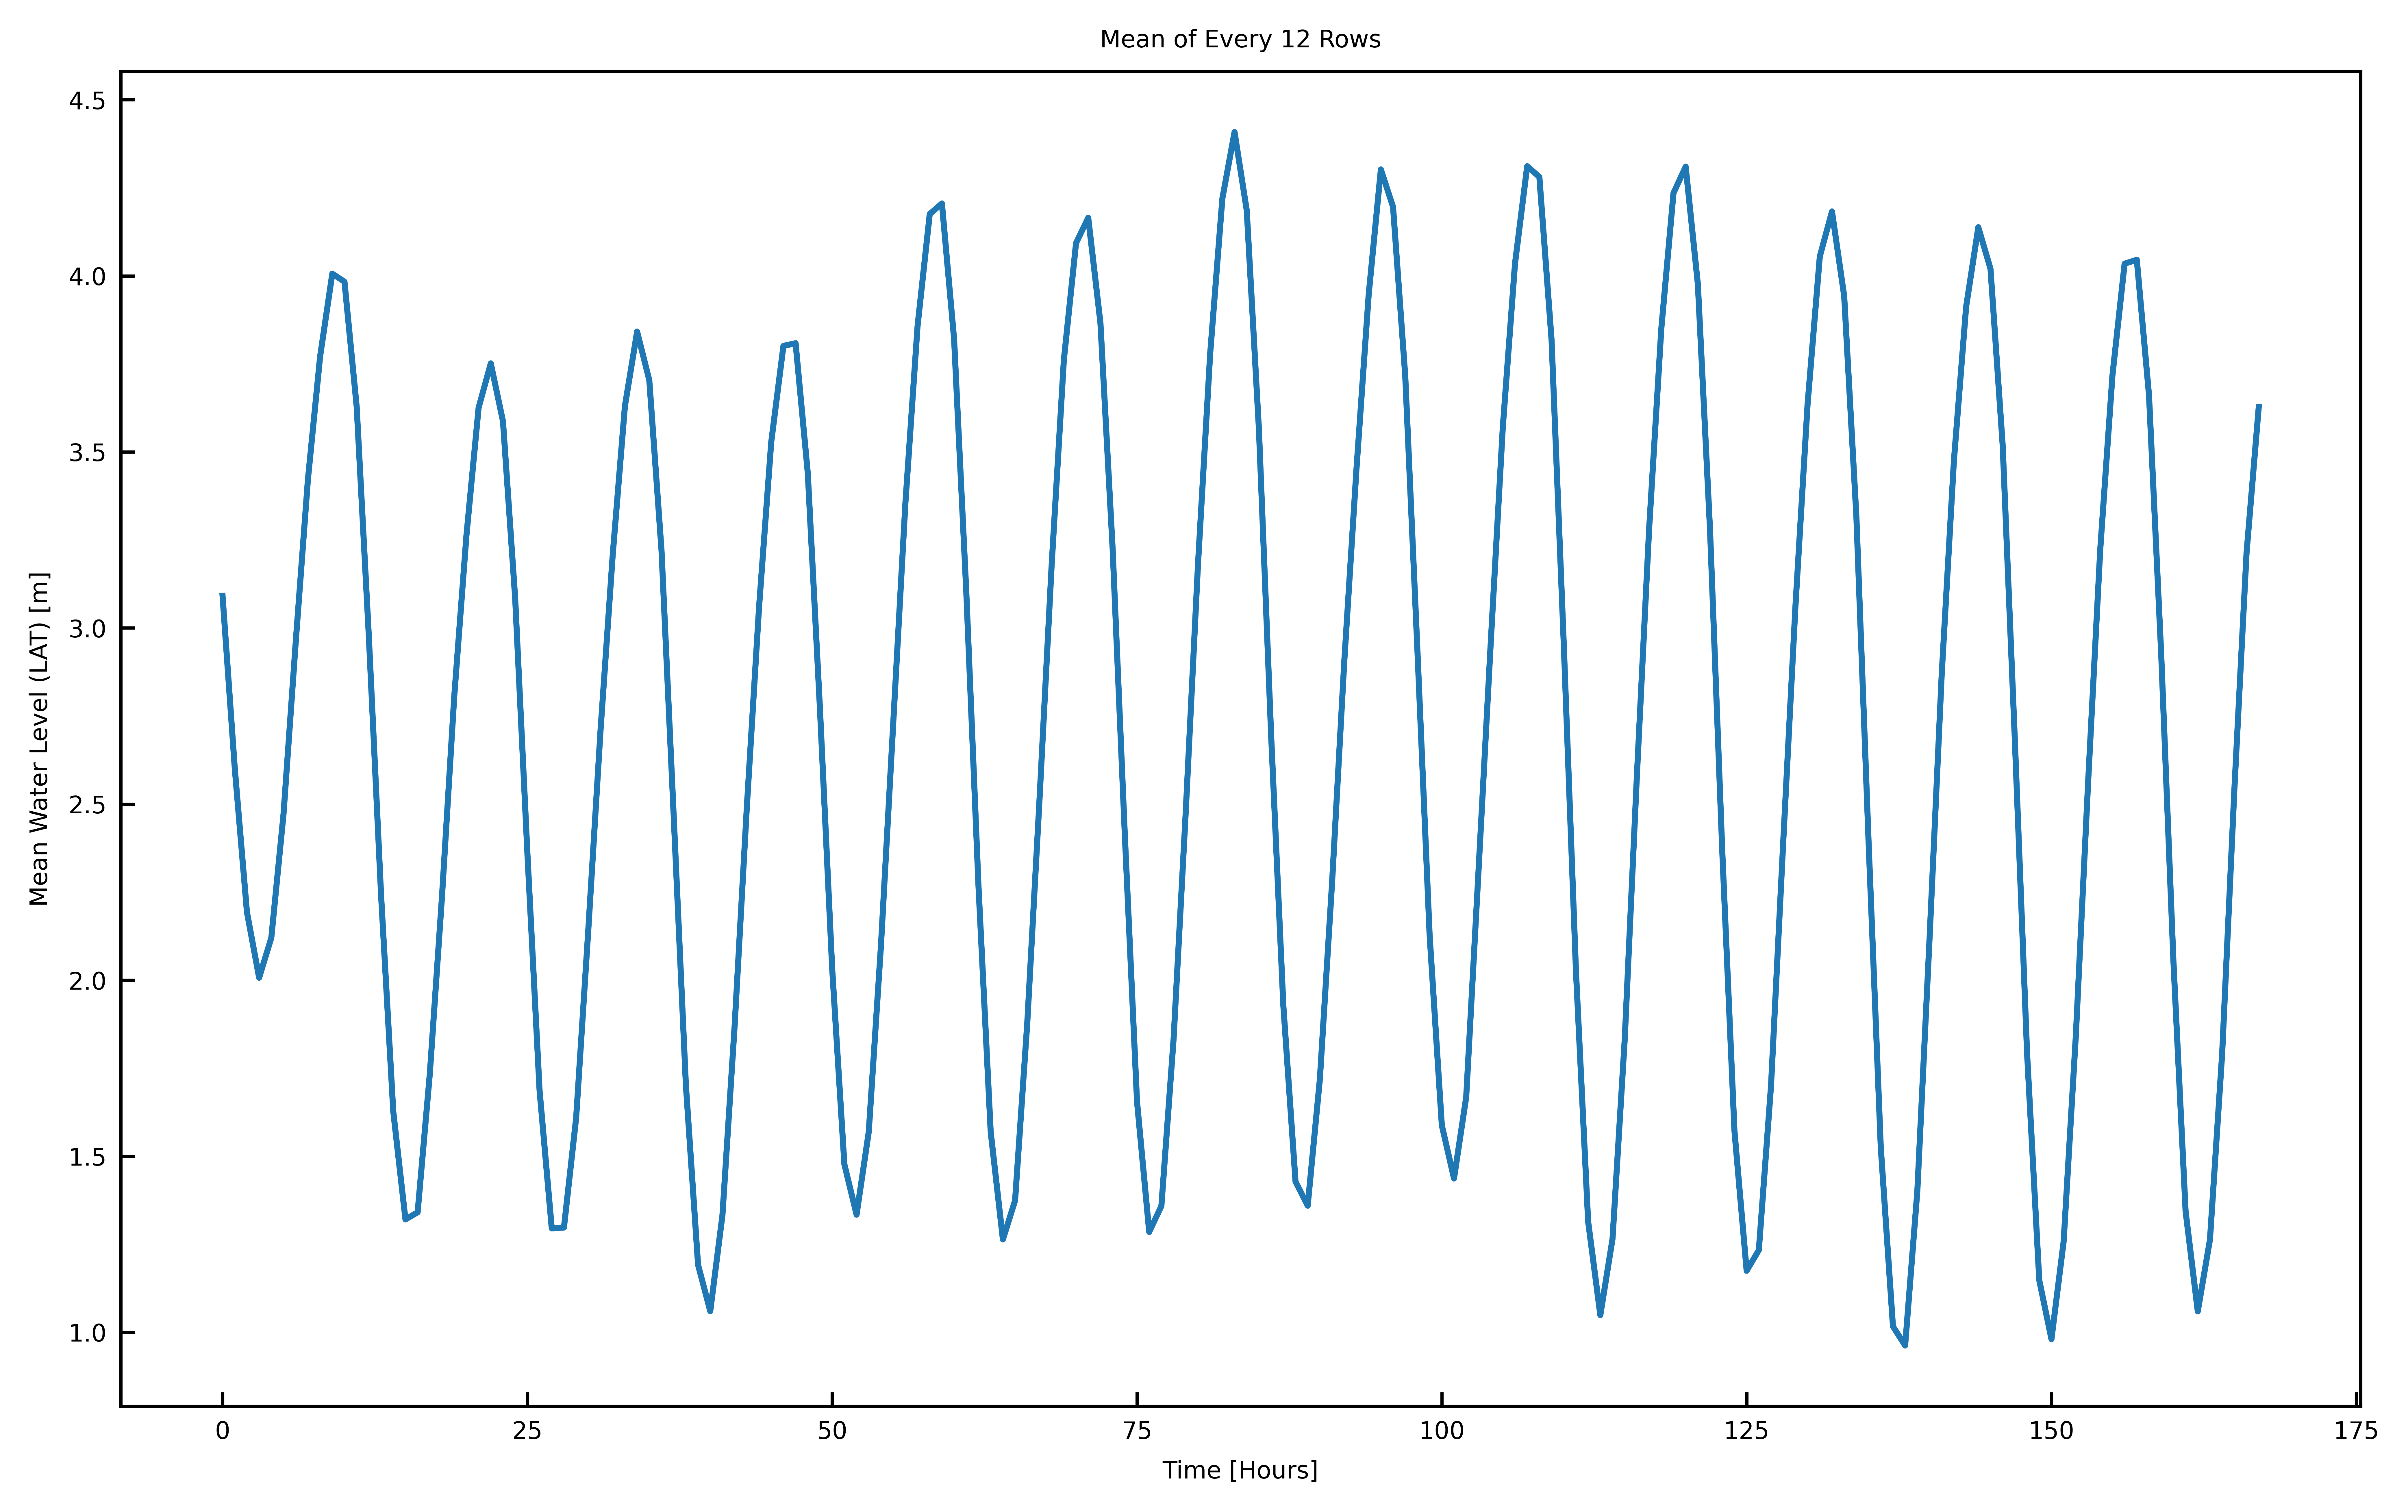

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(mean_every_12_rows.index, mean_every_12_rows.values)
plt.title('Mean of Every 12 Rows')
plt.xlabel('Time [Hours]')
plt.ylabel('Mean Water Level (LAT) [m]')
plt.show()

In [18]:
data = np.array(mean_every_12_rows)
print(data.shape)
print(data[0])

# Rescale the data to be between 0 and 2np.pi
data = (data - data.min())/(data.max() - data.min()) * 2 * np.pi
data[150]

# get training data
train_x = data[:-30]
print(train_x.shape)

# get test data
test_x = data[-30:]
print(test_x.shape)

(168,)
3.091272727272727
(138,)
(30,)


In [19]:
m = 8

n = (m-1)*5

train_matrix = np.tile(train_x, (n, 1)).transpose()
print("train_matrix.shape: ", train_matrix.shape)
train_matrix[:2] 

# prediction matrix
test_matrix = np.tile(test_x, (n, 1)).transpose()
print("test_matrix.shape: ", test_matrix.shape)

train_matrix.shape:  (138, 35)
test_matrix.shape:  (30, 35)


# Create and run circuit

In [20]:
import perceval as pcvl
import lo_reservoir as lrs

t_max_train = train_x.shape[0]
memory_length = 7

simulator = lrs.PhotonicReservoirSimulator(m, t_max_train, overlapping=True)

# generate the layers
_ = simulator.set_circuit_with_stored_layers()

Generating layers: 100%|██████████| 138/138 [00:00<00:00, 378.53it/s]


In [44]:
input_state = pcvl.BasicState([1]*(m-1) + [0]*1)
# input_state = pcvl.BasicState([0, 1, 0, 1, 0, 1, 0, 1])
# train_expectation_matrix = simulator.sequential_expectation_with_memory(train_matrix, 
#                                                                         input_state, memory_length=memory_length)
train_expectation_matrix = simulator.sequential_expectation_calculation(train_matrix, 
                                                                        input_state)
test_expectation_matrix = simulator.sequential_expectation_calculation(test_matrix, 
                                                                        input_state)
print("train_expectations_matrix.shape = ", np.array(train_expectation_matrix).shape)
print("test_expectations_matrix.shape = ", np.array(test_expectation_matrix).shape)

Processing time steps:  22%|██▏       | 31/138 [00:00<00:03, 33.41it/s]


AssertionError: Parameter length mismatch. Expected 1085 parameters, got 1050.

# Prepare data

In [33]:
# Pop the last row of expectations_matrix
expectations_matrix_red = np.array(train_expectation_matrix)[:]
print("expectations_matrix.shape = ", expectations_matrix_red.shape)
labels = np.array(train_x)[:]
data_red = np.array(train_x)[:]

expectations_matrix_red = torch.tensor(expectations_matrix_red).float()
train_x = torch.tensor(data_red).float()

expectations_matrix.shape =  (138, 8)


# Define NN

In [36]:
class SimpleNetwork(nn.Module):
    def __init__(self, input_size):
        self.input_size = input_size
        super(SimpleNetwork, self).__init__()
        self.layer1 = nn.Linear(in_features=self.input_size, out_features=20)
        self.layer2 = nn.Linear(in_features=20, out_features=20)
        self.layer3 = nn.Linear(in_features=20, out_features=1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x.squeeze()  # This will change shape from [batch_size, 1] to [batch_size]


net = SimpleNetwork(input_size=m)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)


# Train the NN

In [45]:
print(expectations_matrix_red.shape)
print(train_x.shape)

torch.Size([138, 8])
torch.Size([138])


In [42]:
dataset = TensorDataset(expectations_matrix_red, train_x)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Training function
def train(model, dataloader, optimizer, epochs):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = F.mse_loss(outputs, targets)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Train the network
train(net, dataloader, optimizer, epochs=100)

# Inference function
def predict(model, inputs):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking
        outputs = model(inputs)
    return outputs

# Example inference
prediction = predict(test_x, torch.tensor(test_matrix).float())
prediction

AttributeError: module 'tqdm' has no attribute 'write'